# Tiny Imagenet

In [19]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [1]:
!python -m pip install torch==2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 55.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 53.3 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 10.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 41.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 23.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 21.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━

In [21]:
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [22]:
#!pip install torcheval

In [2]:
import shutil,timm,os,torch,random,datasets,math
import fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
#import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode
from glob import glob

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

/usr/local/lib/python3.9/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


OSError: libtorch_cuda_cpp.so: cannot open shared object file: No such file or directory

In [24]:
from fastprogress import progress_bar

In [25]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [26]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'tiny-imagenet-200'

In [27]:
url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/tiny-imagenet-200.zip', 'data')

In [28]:
bs = 512

A dataset is defined as just something that has a length and that can be indexed into (we don't have to inherit from anything):

In [29]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True) # the double start (**) is needed for the glob to be recursive
    def __len__(self): return len(self.files)
    def __getitem__(self, i): return self.files[i],Path(self.files[i]).parent.parent.name

In [30]:
tds = TinyDS(path/'train')

In [31]:
tds[0]

('data/tiny-imagenet-200/train/n02814533/images/n02814533_271.JPEG',
 'n02814533')

In [32]:
path_anno = path/'val'/'val_annotations.txt'
anno = dict(o.split('\t')[:2] for o in path_anno.read_text().splitlines())

In [33]:
class TinyValDS(TinyDS):
    def __getitem__(self, i): return self.files[i],anno[os.path.basename(self.files[i])]

In [34]:
vds = TinyValDS(path/'val')

In [35]:
vds[0]

('data/tiny-imagenet-200/val/images/val_3701.JPEG', 'n04560804')

In [36]:
len(tds)

100000

Let's create a class to transform a dataset (fc.noop does not transform anything, it just keeps x or y as is):

In [37]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

In [38]:
id2str = (path/'wnids.txt').read_text().splitlines()
str2id = {v:k for k,v in enumerate(id2str)}

Below we copied and paster the mean and std from a batch of data:

In [39]:
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [40]:
def tfmx(x):
    img = read_image(x, mode=ImageReadMode.RGB)/255 # mode=ImageReadMode.RGB to force 3 channels because 
                                                    # some images are only one channel images
                                                    # / 255 in order to be between 0 and 1
    return (img-xmean[:,None,None])/xstd[:,None,None] # finally, normalize

In [41]:
def tfmy(y): return tensor(str2id[y])

In [42]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [43]:
xi,yi = tfm_tds[0]
id2str[yi]

'n02814533'

To show the images we need to denormalize them:

In [44]:
def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clip(0,1)

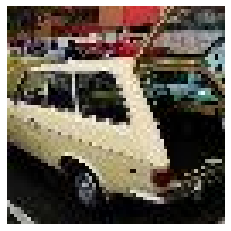

In [45]:
show_image(denorm(xi));

In [46]:
dltrn = DataLoader(tfm_tds, batch_size=bs, shuffle=True, num_workers=8)

In [47]:
xb,yb = b = next(iter(dltrn))

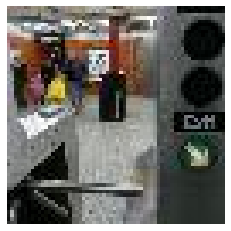

In [48]:
show_image(denorm(xb[0]));

In [49]:
all_synsets = [o.split('\t') for o in (path/'words.txt').read_text().splitlines()]
synsets = {k:v.split(',', maxsplit=1)[0] for k,v in all_synsets if k in id2str}

In [50]:
titles = [synsets[id2str[o]] for o in yb]
', '.join(titles[:20])

'turnstile, bucket, king penguin, stopwatch, albatross, guinea pig, syringe, bathtub, scoreboard, vestment, teapot, bathtub, chimpanzee, limousine, suspension bridge, brain coral, bucket, black widow, picket fence, water jug'

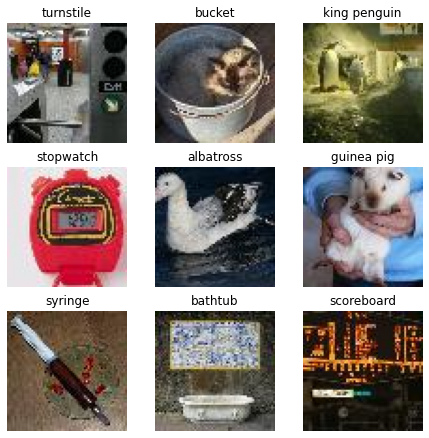

In [51]:
show_images(denorm(xb[:9]), titles=titles[:9], imsize=2.5)

In [52]:
get_dls??

Signature: get_dls(train_ds, valid_ds, bs, **kwargs)
Docstring: <no docstring>
Source:   
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))
File:      /notebooks/course22p2/nbs/miniai/training.py
Type:      function


In [54]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

## Basic model

Random resize crop is going to work poorly on 64x64 images. So we're just going to add some padding and crop a 64x64 area.

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [ ]:
tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64), # T. is for Torchvision transforms which are nn.modules
                     T.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

In [ ]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [ ]:
nfs = (32,64,128,256,512,1024)

In [ ]:
def get_dropmodel(act=act_gr, nfs=nfs, norm=nn.BatchNorm2d, drop=0.1):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
#     layers += [ResBlock(nfs[0], nfs[0], ks=3, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

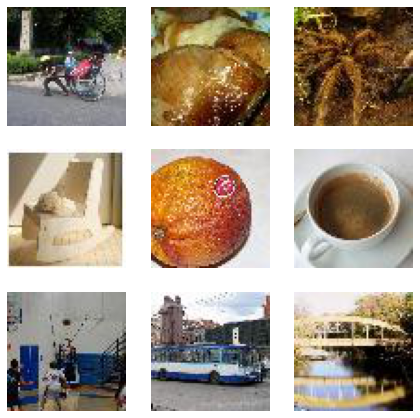

In [ ]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
learn.summary()

Tot params: 19775824; MFLOPS: 303.7


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Conv2d|(512, 3, 64, 64)|(512, 32, 64, 64)|2432|9.8|
|ResBlock|(512, 32, 64, 64)|(512, 64, 32, 32)|57792|58.7|
|ResBlock|(512, 64, 32, 32)|(512, 128, 16, 16)|230272|58.7|
|ResBlock|(512, 128, 16, 16)|(512, 256, 8, 8)|919296|58.7|
|ResBlock|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|ResBlock|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


In [ ]:
opt_func = partial(optim.AdamW, eps=1e-5)

In [ ]:
lr_cbs = [DeviceCB(), augcb, MixedPrecision(), ProgressCB()]

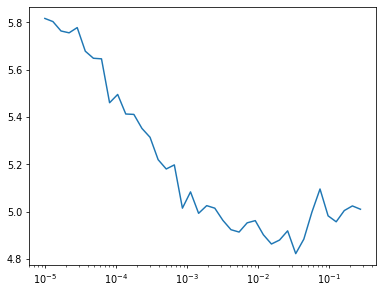

In [ ]:
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

In [ ]:
epochs = 25
lr = 0.1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.112,4.370,0,train
0.169,3.852,0,eval
0.224,3.580,1,train
0.245,3.385,1,eval
0.272,3.244,2,train
0.241,3.557,2,eval
0.306,3.025,3,train
0.228,3.717,3,eval
0.336,2.856,4,train
0.280,3.414,4,eval


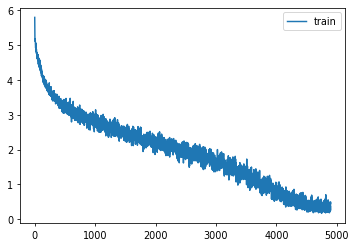

In [ ]:
learn.fit(epochs)

On __[paperswithcode](https://paperswithcode.com/sota/image-classification-on-tiny-imagenet-1)__ the best models without pre-training are about 72% accurate.

In [ ]:
torch.save(learn.model, 'models/inettiny-basic-25')

## Deeper

In [ ]:
def res_blocks(n_bk, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
    return nn.Sequential(*[
        ResBlock(ni if i==0 else nf, nf, stride=stride if i==n_bk-1 else 1, ks=ks, act=act, norm=norm)
        for i in range(n_bk)])

Number of resblocks before a downsample of the grid size:

In [ ]:
nbks = (3,2,2,1,1)

In [ ]:
def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

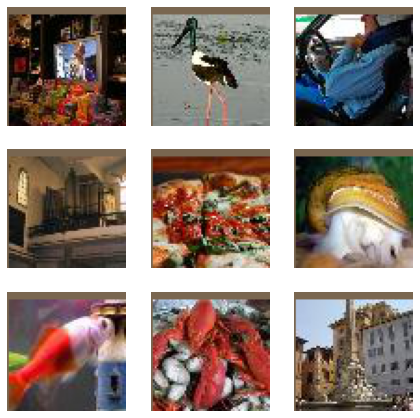

In [ ]:
learn = TrainLearner(get_dropmodel(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augcb, DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
learn.summary()

Tot params: 21426800; MFLOPS: 710.9


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(512, 3, 64, 64)|(512, 32, 64, 64)|28320|115.1|
|Sequential|(512, 32, 64, 64)|(512, 64, 32, 32)|206016|209.7|
|Sequential|(512, 64, 32, 32)|(512, 128, 16, 16)|525952|134.2|
|Sequential|(512, 128, 16, 16)|(512, 256, 8, 8)|2100480|134.2|
|Sequential|(512, 256, 8, 8)|(512, 512, 4, 4)|3673600|58.7|
|Sequential|(512, 512, 4, 4)|(512, 1024, 2, 2)|14687232|58.7|
|AdaptiveAvgPool2d|(512, 1024, 2, 2)|(512, 1024, 1, 1)|0|0.0|
|Flatten|(512, 1024, 1, 1)|(512, 1024)|0|0.0|
|Dropout|(512, 1024)|(512, 1024)|0|0.0|
|Linear|(512, 1024)|(512, 200)|204800|0.2|
|BatchNorm1d|(512, 200)|(512, 200)|400|0.0|


In [ ]:
opt_func = partial(optim.AdamW, eps=1e-5)

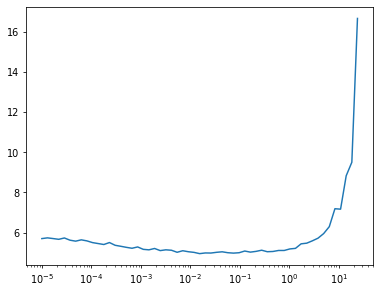

In [ ]:
learn = Learner(get_dropmodel(), dls, F.cross_entropy, cbs=lr_cbs, opt_func=opt_func)
learn.lr_find()

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

epochs = 25
lr = 3e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
learn = Learner(get_dropmodel(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.073,4.595,0,train
0.099,4.283,0,eval
0.175,3.825,1,train
0.192,3.682,1,eval
0.238,3.393,2,train
0.203,3.798,2,eval
0.291,3.075,3,train
0.248,3.404,3,eval
0.329,2.873,4,train
0.275,3.290,4,eval


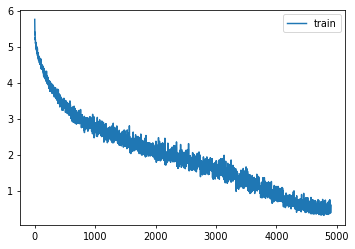

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/inettiny-custom-25')

## More augmentation

We woulde like to use TrivialAugmentWide now, which is built into Pytorch.

The problem with doing augmentation on a per batch level is that if the augmentation is too much for one batch, since all items in the batch are impacting the loss, then the loss is going to be totally messed up.

So let's see how to do augmentation on a per item level.

In [ ]:
aug_tfms = nn.Sequential(T.Pad(4), T.RandomCrop(64),
                     T.RandomHorizontalFlip(),
                     T.TrivialAugmentWide())

norm_tfm = T.Normalize(xmean, xstd)
erase_tfm = RandErase()

Some of the Pytorch transforms require a PIL image, not a tensor.

In [ ]:
from PIL import Image

In [58]:
RandErase??

Init signature: RandErase(pct=0.2, max_num=4)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:ivar training: Boolean represents whether this module is in training or
                evaluat

In [ ]:
def tfmx(x, aug=False):
    x = Image.open(x).convert('RGB')
    if aug: x = aug_tfms(x)
    x = TF.to_tensor(x)
    x = norm_tfm(x) # normalize using Torchvision's Normalize  
    if aug: x = erase_tfm(x[None])[0] # RandErase was designed to use  0 mean 1 std distributed 
                                      # gaussian noise, so we want that to happen after normalization
    return x

In [ ]:
tfm_tds = TfmDS(tds, partial(tfmx, aug=True), tfmy) # do augmentation only for the training set
tfm_vds = TfmDS(vds, tfmx, tfmy)

Now we don't need any augmentation callback.

In [ ]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

Now we're going to do pre-activation resnets.

In the __[Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)__ paper, in the illustation we can see that due to the last activation, in the original resnet there was not a pure identity path.

In [ ]:
def conv(ni, nf, ks=3, stride=1, act=nn.ReLU, norm=None, bias=True):
    layers = []
    if norm: layers.append(norm(ni))
    if act : layers.append(act())
    layers.append(nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias))
    return nn.Sequential(*layers)

def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1     , act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=act, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None, norm=norm)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return self.convs(x) + self.idconv(self.pool(x))

def get_dropmodel(act=act_gr, nfs=nfs, nbks=nbks, norm=nn.BatchNorm2d, drop=0.2):
    layers = [nn.Conv2d(3, nfs[0], 5, padding=2)]
    layers += [res_blocks(nbks[i], nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
               for i in range(len(nfs)-1)]
    layers += [act_gr(), norm(nfs[-1]), nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Dropout(drop)]
    layers += [nn.Linear(nfs[-1], 200, bias=False), nn.BatchNorm1d(200)]
    return nn.Sequential(*layers).apply(iw)

In [ ]:
def get_model(): return get_dropmodel(nbks=(4,3,3,2,1), drop=0.1)

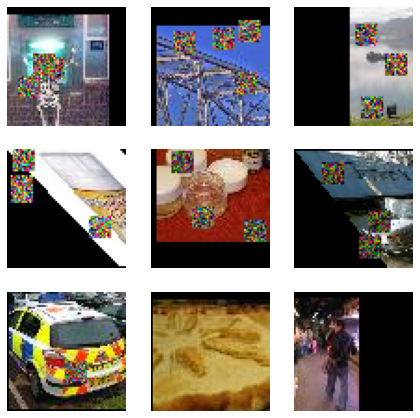

In [ ]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, cbs=[SingleBatchCB(), DeviceCB()])
learn.fit(1)
xb,yb = learn.batch
show_images(denorm(xb.cpu())[:9], imsize=2.5)

In [ ]:
epochs = 50
lr = 0.1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model(), dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

accuracy,loss,epoch,train
0.026,5.044,0,train
0.035,4.920,0,eval
0.052,4.712,1,train
0.075,4.434,1,eval
0.086,4.417,2,train
0.108,4.135,2,eval
0.121,4.149,3,train
0.141,4.008,3,eval
0.153,3.908,4,train
0.180,3.725,4,eval


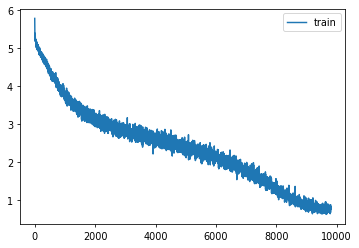

In [ ]:
learn.fit(epochs)

In [ ]:
torch.save(learn.model, 'models/inettiny-trivaug-50')

### fin -